Starting Multimodal Housing Price Prediction
Dataset created successfully!
Dataset shape: (19, 6)
Columns: ['image_id', 'n_citi', 'bed', 'bath', 'sqft', 'price']
Price range: $195,000 to $1,995,000
Original dataset shape: (19, 6)
After removing duplicates: (19, 6)
After removing missing values: (19, 6)
Generated 19 synthetic images
Tabular data shape: (19, 4)
Images shape: (19, 128, 128, 3)
Target shape: (19,)
Training multimodal model...
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - loss: 632821710848.0000 - mae: 584488.9375 - val_loss: 1164142182400.0000 - val_mae: 824639.7500 - learning_rate: 0.0010
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 632805654528.0000 - mae: 584477.2500 - val_loss: 1164100763648.0000 - val_mae: 824614.8125 - learning_rate: 0.0010
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 632763645952.0000 - mae: 584438.4375 - val_loss: 1164010192896.0000 - val_mae: 824560.5000 - learning_rate: 0.0010
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 

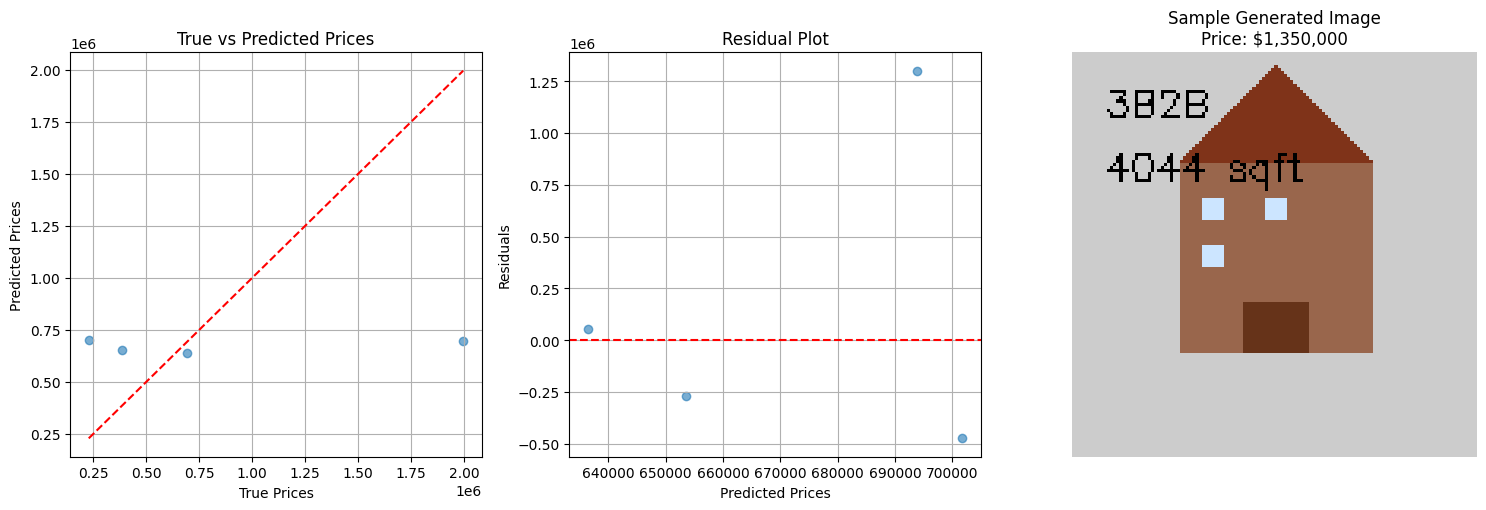


Feature Importance from Random Forest:
  feature  importance
3    sqft    0.875951
0  n_citi    0.058445
1     bed    0.044633
2    bath    0.020971

Analysis complete!


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import cv2
import os

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 1. Create the dataset from your provided data
def create_housing_dataset():
    """Create the housing dataset from the provided data"""
    data = {
        'image_id': [1, 4, 6, 7, 8, 9, 10, 11, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25],
        'n_citi': [48, 55, 55, 48, 48, 317, 129, 122, 122, 122, 122, 367, 367, 20, 57, 24, 122, 57, 24],
        'bed': [3, 4, 4, 5, 5, 4, 3, 5, 5, 3, 8, 4, 4, 4, 5, 3, 3, 3, 2],
        'bath': [2, 3, 3, 2, 2, 5, 2, 5, 5, 3, 3, 1, 2, 2, 3, 2, 2, 2, 1],
        'sqft': [713, 2547, 2769, 2600, 2600, 3932, 4044, 6247, 6247, 4597, 4236, 1980, 1967, 1573, 2065, 1087, 1400, 1533, 966],
        'price': [228500, 385100, 415000, 545000, 545000, 690000, 1350000, 1499000, 1499000, 1550000, 1850000, 1995000, 249950, 205000, 249000, 195000, 229000, 229000, 239900]
    }

    df = pd.DataFrame(data)
    print("Dataset created successfully!")
    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    print(f"Price range: ${df['price'].min():,} to ${df['price'].max():,}")

    return df

# 2. Data Preparation
class HousingDataProcessor:
    def __init__(self, image_size=(128, 128)):
        self.image_size = image_size
        self.scaler = StandardScaler()

    def preprocess_data(self, df):
        """Preprocess the dataset"""
        print(f"Original dataset shape: {df.shape}")

        # Handle duplicates
        df = df.drop_duplicates()
        print(f"After removing duplicates: {df.shape}")

        # Handle missing values
        df = df.dropna()
        print(f"After removing missing values: {df.shape}")

        # Separate features and target
        X_tabular = df[['n_citi', 'bed', 'bath', 'sqft']]
        y = df['price'].values

        # Scale tabular features
        X_tabular_scaled = self.scaler.fit_transform(X_tabular)

        # Generate synthetic images based on features
        images = self._generate_synthetic_images(df)

        return X_tabular_scaled, images, y, df

    def _generate_synthetic_images(self, df):
        """Generate synthetic house images based on features"""
        images = []

        for _, row in df.iterrows():
            # Create image based on house features
            img = self._create_house_image(
                bedrooms=row['bed'],
                bathrooms=row['bath'],
                sqft=row['sqft'],
                price=row['price']
            )
            images.append(img)

        print(f"Generated {len(images)} synthetic images")
        return np.array(images)

    def _create_house_image(self, bedrooms, bathrooms, sqft, price):
        """Create a synthetic house image visualization"""
        img = np.ones((self.image_size[0], self.image_size[1], 3), dtype=np.float32) * 0.8

        # Draw house based on features
        house_size = min(80, 20 + bedrooms * 10 + bathrooms * 5)
        house_color = (0.6, 0.4, 0.3)  # Brown

        # Draw house body
        center_x, center_y = self.image_size[1] // 2, self.image_size[0] // 2
        cv2.rectangle(img,
                     (center_x - house_size//2, center_y - house_size//2),
                     (center_x + house_size//2, center_y + house_size//2),
                     house_color, -1)

        # Draw roof
        roof_points = np.array([
            [center_x - house_size//2, center_y - house_size//2],
            [center_x + house_size//2, center_y - house_size//2],
            [center_x, center_y - house_size]
        ], np.int32)
        cv2.fillPoly(img, [roof_points], (0.5, 0.2, 0.1))

        # Draw windows
        window_size = house_size // 8
        for i in range(bedrooms):
            window_x = center_x - house_size//3 + (i % 2) * house_size//3
            window_y = center_y - house_size//4 + (i // 2) * house_size//4
            cv2.rectangle(img,
                         (window_x - window_size//2, window_y - window_size//2),
                         (window_x + window_size//2, window_y + window_size//2),
                         (0.8, 0.9, 1.0), -1)

        # Draw door
        cv2.rectangle(img,
                     (center_x - house_size//6, center_y + house_size//4),
                     (center_x + house_size//6, center_y + house_size//2),
                     (0.4, 0.2, 0.1), -1)

        # Add text info
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, f'{bedrooms}B{int(bathrooms)}B', (10, 20), font, 0.4, (0, 0, 0), 1)
        cv2.putText(img, f'{sqft} sqft', (10, 40), font, 0.4, (0, 0, 0), 1)

        return img

# 3. Multimodal Model
class MultimodalHousingModel:
    def __init__(self, tabular_input_dim, image_input_shape=(128, 128, 3)):
        self.tabular_input_dim = tabular_input_dim
        self.image_input_shape = image_input_shape
        self.model = self._build_model()

    def _build_model(self):
        """Build multimodal model"""
        # Image branch
        image_input = layers.Input(shape=self.image_input_shape, name='image_input')
        x_image = layers.Conv2D(16, (3, 3), activation='relu')(image_input)
        x_image = layers.MaxPooling2D((2, 2))(x_image)
        x_image = layers.Conv2D(32, (3, 3), activation='relu')(x_image)
        x_image = layers.MaxPooling2D((2, 2))(x_image)
        x_image = layers.Flatten()(x_image)
        x_image = layers.Dense(16, activation='relu')(x_image)
        x_image = layers.Dropout(0.3)(x_image)

        # Tabular branch
        tabular_input = layers.Input(shape=(self.tabular_input_dim,), name='tabular_input')
        x_tabular = layers.Dense(8, activation='relu')(tabular_input)
        x_tabular = layers.Dropout(0.2)(x_tabular)

        # Fusion
        combined = layers.concatenate([x_image, x_tabular])

        # Regression head
        x = layers.Dense(16, activation='relu')(combined)
        x = layers.Dropout(0.3)(x)
        output = layers.Dense(1, activation='linear', name='output')(x)

        model = models.Model(
            inputs=[image_input, tabular_input],
            outputs=output
        )

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae']
        )

        return model

    def train(self, X_image, X_tabular, y, epochs=100, batch_size=4):
        """Train the model"""
        # Split data
        (X_image_train, X_image_test,
         X_tabular_train, X_tabular_test,
         y_train, y_test) = train_test_split(
            X_image, X_tabular, y, test_size=0.2, random_state=42
        )

        callbacks = [
            keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=10)
        ]

        print("Training multimodal model...")
        history = self.model.fit(
            [X_image_train, X_tabular_train],
            y_train,
            validation_data=([X_image_test, X_tabular_test], y_test),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )

        return history, (X_image_test, X_tabular_test, y_test)

    def evaluate(self, X_image, X_tabular, y):
        """Evaluate model performance"""
        predictions = self.model.predict([X_image, X_tabular], verbose=0)

        mae = mean_absolute_error(y, predictions)
        rmse = np.sqrt(mean_squared_error(y, predictions))

        return mae, rmse, predictions.flatten()

# 4. Main Execution
def main():
    print("Starting Multimodal Housing Price Prediction")
    print("=" * 50)

    # Create dataset from your data
    df = create_housing_dataset()

    # Initialize processor
    processor = HousingDataProcessor(image_size=(128, 128))

    # Preprocess data
    X_tabular, images, y, df = processor.preprocess_data(df)

    print(f"Tabular data shape: {X_tabular.shape}")
    print(f"Images shape: {images.shape}")
    print(f"Target shape: {y.shape}")

    # Initialize and train multimodal model
    multimodal_model = MultimodalHousingModel(X_tabular.shape[1])

    history, (X_image_test, X_tabular_test, y_test) = multimodal_model.train(
        images, X_tabular, y, epochs=100, batch_size=4
    )

    # Evaluate multimodal model
    mae, rmse, predictions = multimodal_model.evaluate(X_image_test, X_tabular_test, y_test)

    print("\nMultimodal Model Results:")
    print(f"MAE: ${mae:,.2f}")
    print(f"RMSE: ${rmse:,.2f}")

    # Compare with tabular-only baseline
    print("\nComparison with Tabular-Only Baseline:")

    # Tabular-only model
    X_tabular_train, X_tabular_test, y_train, y_test = train_test_split(
        X_tabular, y, test_size=0.2, random_state=42
    )

    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_tabular_train, y_train)
    rf_pred = rf_model.predict(X_tabular_test)

    rf_mae = mean_absolute_error(y_test, rf_pred)
    rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))

    print(f"Tabular Only - MAE: ${rf_mae:,.2f}")
    print(f"Tabular Only - RMSE: ${rf_rmse:,.2f}")

    # Calculate improvement
    mae_improvement = ((rf_mae - mae) / rf_mae) * 100
    rmse_improvement = ((rf_rmse - rmse) / rf_rmse) * 100

    print(f"\nImprovement with Multimodal Approach:")
    print(f"MAE Improvement: {mae_improvement:+.1f}%")
    print(f"RMSE Improvement: {rmse_improvement:+.1f}%")

    # Visualization
    plt.figure(figsize=(15, 5))

    # Plot 1: True vs Predicted
    plt.subplot(1, 3, 1)
    plt.scatter(y_test, predictions, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('True Prices')
    plt.ylabel('Predicted Prices')
    plt.title('True vs Predicted Prices')
    plt.grid(True)

    # Plot 2: Residuals
    plt.subplot(1, 3, 2)
    residuals = y_test - predictions
    plt.scatter(predictions, residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Prices')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.grid(True)

    # Plot 3: Sample generated images
    plt.subplot(1, 3, 3)
    sample_idx = np.random.randint(0, len(images))
    plt.imshow(images[sample_idx])
    plt.title(f'Sample Generated Image\nPrice: ${y[sample_idx]:,}')
    plt.axis('off')

    plt.tight_layout()
    plt.savefig('multimodal_housing_results.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Show feature importance
    print("\nFeature Importance from Random Forest:")
    feature_importance = pd.DataFrame({
        'feature': ['n_citi', 'bed', 'bath', 'sqft'],
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print(feature_importance)

    print(f"\nAnalysis complete!")

# Run the complete pipeline
if __name__ == "__main__":
    main()